In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models, utils
from tqdm import tqdm
import numpy as np
import pandas as pd
# from torchsummary import summary


In [6]:
class SparseConv(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size):
        super().__init__()

        padding = kernel_size//2

        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False)

        self.bias = nn.Parameter(
            torch.zeros(out_channels), 
            requires_grad=True)

        self.sparsity = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False)

        kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)

        self.sparsity.weight = nn.Parameter(
            data=kernel, 
            requires_grad=False)

        self.relu = nn.ReLU(inplace=True)


        self.max_pool = nn.MaxPool2d(
            kernel_size, 
            stride=1, 
            padding=padding)

        

    def forward(self, x, mask):
        x = x*mask
        x = self.conv(x)
        normalizer = 1/(self.sparsity(mask)+1e-8)
        x = x * normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        x = self.relu(x)
        
        mask = self.max_pool(mask)

        return x, mask




class SparseConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        #self.SparseLayer1 = SparseConv(1, 16, 11)
        #self.SparseLayer2 = SparseConv(16, 16, 7)
        #self.SparseLayer3 = SparseConv(16, 16, 5)
        self.SparseLayer3 = SparseConv(1, 16, 5)
        #self.SparseLayer4 = SparseConv(16, 16, 3)
        #self.SparseLayer5 = SparseConv(16, 16, 3)
        self.SparseLayer6 = SparseConv(16, 1, 1)
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
        #self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x, mask):
        #x, mask = self.SparseLayer1(x, mask)
        #x, mask = self.SparseLayer2(x, mask)
        x, mask = self.SparseLayer3(x, mask)
        #x, mask = self.SparseLayer4(x, mask)
        #x, mask = self.SparseLayer5(x, mask)
        x, mask = self.SparseLayer6(x, mask)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc1(x)

        return x

In [7]:
class SparseDatasetMNIST(Dataset):
    def __init__(self, file_path, transform=None, sparsity_level=0.0):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.sparsity_level = sparsity_level

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # generate the random mask
        tensor_length = 28 * 28
        ones_count = int(tensor_length * self.sparsity_level)
        ones_indices = torch.randperm(tensor_length)[:ones_count]
        random_mask = torch.zeros(tensor_length).bool()
        random_mask[ones_indices] = 1
        random_mask = random_mask.reshape((28, 28, 1))

        # generate the sparse image
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        image = torch.from_numpy(image)
        processed_image = image.masked_fill(random_mask, 0).numpy()
        label = self.data.iloc[index, 0]

        if self.transform is not None:
            # print("---")
            processed_image = self.transform(processed_image)

        
        return processed_image, random_mask.reshape((1,28,28)).float(), label

In [14]:
def train(train_loader, model, optimizer, criterion, device):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        model: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
        device: whether the network runs on cpu or gpu
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Switch to train mode
    model.train()

    # Iterate through batches
    for i, data in enumerate(train_loader):
        
        ##########
        # Get the inputs; data is a list of [inputs, labels]
        inputs, mask, labels = data

        # Move data to target device
        inputs, mask, labels = inputs.to(device), mask.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        # Forward propagation
        mask = (inputs > 0).float()
        outputs = model(inputs, mask)

        # Loss computation
        loss = (criterion(outputs, labels) * mask.detach()).sum() / mask.sum()
        ############

        loss.backward()
        optimizer.step()

        # Keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss / len(train_loader), 100 * correct / total

In [15]:
def test(test_loader, model, criterion, device):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        model: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Switch to test mode
    model.eval()

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # Iterate through batches
        for data in test_loader:
            
        
            ###########
            # Get the inputs; data is a list of [inputs, labels]
            inputs, mask, labels = data

            # Move data to target device
            inputs, mask, labels = inputs.to(device), mask.to(device), labels.to(device)

            # Forward + backward + optimize
            # Forward propagation
            mask = (inputs > 0).float()
            outputs = model(inputs, mask)

            # Loss computation
            loss = (criterion(outputs, labels) * mask.detach()).sum() / mask.sum()
            ###########


            # Keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss / len(test_loader), 100 * correct / total

In [10]:
# hyperparameters
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.005
weight_decay = 1e-3
#momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)
spar_level = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# mps_avail = torch.backends.mps.is_available()
# print(f"Is the mps available? {mps_avail}")


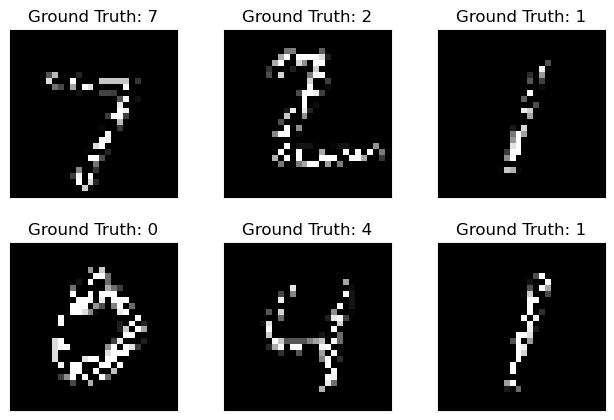

In [12]:

the_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ])
spar_level = 0.5
training_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_train.csv', transform=the_transform, sparsity_level=spar_level)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)

test_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_test.csv', transform=the_transform, sparsity_level=spar_level)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle= False)

# draw some examples
examples = enumerate(test_loader)
batch_idx, (example_data, example_mask, example_targets) = next(examples)
#batch_idx, (example_data, example_targets) = next(examples)
# print(example_targets)
# print(example_data.shape)
'''
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_mask[i][0], cmap='gray', interpolation='none')
    plt.title("Example random mask")
    plt.xticks([])
    plt.yticks([])
plt.show()
'''
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()



In [17]:

# Create classifier model
#model = ConvNet()
model = SparseConvNet()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Use GPU if available
model = model.to(device)


train_losses = []
train_accuracy = []
train_counter = []
test_losses = []
test_accuracy = []
#test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

for epoch in tqdm(range(n_epochs)):
    # Train on data
    train_loss, train_acc = train(train_loader, model, optimizer, criterion, device)

    # Test on data
    #test_loss, test_acc = test(test_loader, model, criterion, device)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    #test_losses.append(test_loss)
    #test_accuracy.append(test_acc)

    print('\nTraining set: Epoch: {:.0f}, Avg. loss: {:.4f}, Accuracy: {:.4f}%)'.format(
        epoch, train_loss, train_acc))
    #print('\nTest set: Epoch: {:.0f}, Avg. loss: {:.4f}, Accuracy: {:.4f}%)'.format(
     #   epoch, test_loss, test_acc))

# Test on data
test_loss, test_acc = test(test_loader, model, criterion, device)
print('\nTest set: Epoch: {:.0f}, Avg. loss: {:.4f}, Accuracy: {:.4f}%)'.format(
        epoch, test_loss, test_acc))

print('\nFinished.')

 10%|█         | 1/10 [00:14<02:06, 14.06s/it]


Training set: Epoch: 0, Avg. loss: 0.9652, Accuracy: 67.5717%)


 20%|██        | 2/10 [00:27<01:52, 14.00s/it]


Training set: Epoch: 1, Avg. loss: 0.9241, Accuracy: 69.1867%)


 30%|███       | 3/10 [00:41<01:37, 13.91s/it]


Training set: Epoch: 2, Avg. loss: 0.9128, Accuracy: 69.6067%)


 40%|████      | 4/10 [00:55<01:23, 13.93s/it]


Training set: Epoch: 3, Avg. loss: 0.9075, Accuracy: 69.8567%)


 50%|█████     | 5/10 [01:09<01:09, 13.83s/it]


Training set: Epoch: 4, Avg. loss: 0.9104, Accuracy: 69.7750%)


 60%|██████    | 6/10 [01:22<00:54, 13.72s/it]


Training set: Epoch: 5, Avg. loss: 0.8993, Accuracy: 69.9500%)


 70%|███████   | 7/10 [01:36<00:41, 13.70s/it]


Training set: Epoch: 6, Avg. loss: 0.8950, Accuracy: 70.1450%)


 80%|████████  | 8/10 [01:49<00:27, 13.61s/it]


Training set: Epoch: 7, Avg. loss: 0.9000, Accuracy: 70.0017%)


 90%|█████████ | 9/10 [02:03<00:13, 13.76s/it]


Training set: Epoch: 8, Avg. loss: 0.8941, Accuracy: 70.2900%)


100%|██████████| 10/10 [02:17<00:00, 13.77s/it]


Training set: Epoch: 9, Avg. loss: 0.8931, Accuracy: 70.3333%)



Test set: Epoch: 9, Avg. loss: 0.8445, Accuracy: 72.7800%)

Finished.


In [16]:

spar_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
batch_size_train = 64
batch_size_test = 1000
n_epochs = 10  
learning_rate = 0.01
momentum = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(len(spar_levels)):
    the_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    sparsity_level = spar_levels[i]

    training_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_train.csv',
                                      transform=the_transform, sparsity_level=sparsity_level)
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)

    test_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_test.csv',
                                  transform=the_transform, sparsity_level=sparsity_level)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

    model = SparseConvNet()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)

    train_losses = []
    train_accuracy = []
    train_counter = []
    test_losses = []
    test_accuracy = []

    for epoch in tqdm(range(n_epochs)):
        # Train on data
        train_loss, train_acc = train(train_loader, model, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        # Test on data
        test_loss, test_acc = test(test_loader, model, criterion, device)
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)

    print('\nFinished training for Sparsity Level: {}'.format(sparsity_level))
    print('\nTest Loss: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_acc))


100%|██████████| 10/10 [02:26<00:00, 14.68s/it]



Finished training for Sparsity Level: 0

Test Loss: 0.1863, Test Acc: 94.4800


100%|██████████| 10/10 [02:30<00:00, 15.00s/it]



Finished training for Sparsity Level: 0.1

Test Loss: 0.1884, Test Acc: 94.7200


100%|██████████| 10/10 [02:29<00:00, 15.00s/it]



Finished training for Sparsity Level: 0.2

Test Loss: 0.1761, Test Acc: 94.6100


100%|██████████| 10/10 [02:30<00:00, 15.02s/it]



Finished training for Sparsity Level: 0.3

Test Loss: 0.1949, Test Acc: 93.9700


100%|██████████| 10/10 [02:32<00:00, 15.25s/it]



Finished training for Sparsity Level: 0.4

Test Loss: 0.2270, Test Acc: 92.9500


100%|██████████| 10/10 [02:31<00:00, 15.15s/it]



Finished training for Sparsity Level: 0.5

Test Loss: 0.3066, Test Acc: 90.2300


100%|██████████| 10/10 [02:32<00:00, 15.24s/it]



Finished training for Sparsity Level: 0.6

Test Loss: 0.3628, Test Acc: 89.0300


100%|██████████| 10/10 [02:29<00:00, 14.96s/it]



Finished training for Sparsity Level: 0.7

Test Loss: 0.4005, Test Acc: 87.8600


100%|██████████| 10/10 [02:29<00:00, 14.94s/it]



Finished training for Sparsity Level: 0.8

Test Loss: 0.5101, Test Acc: 84.0200


100%|██████████| 10/10 [02:30<00:00, 15.00s/it]


Finished training for Sparsity Level: 0.9

Test Loss: 0.8547, Test Acc: 71.8500


In [17]:
spar_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
batch_size_train = 64
batch_size_test = 1000
n_epochs = 20  
learning_rate = 0.005
weight_decay = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(len(spar_levels)):
    the_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    sparsity_level = spar_levels[i]

    training_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_train.csv',
                                      transform=the_transform, sparsity_level=sparsity_level)
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)

    test_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_test.csv',
                                  transform=the_transform, sparsity_level=sparsity_level)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

    model = SparseConvNet()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model = model.to(device)

    train_losses = []
    train_accuracy = []
    train_counter = []
    test_losses = []
    test_accuracy = []

    for epoch in tqdm(range(n_epochs)):
        # Train on data
        train_loss, train_acc = train(train_loader, model, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        print('\nTraining for Sparsity Level: {}'.format(sparsity_level))
        print('\nTraining Loss: {:.4f}, Training Acc: {:.4f}'.format(train_loss, train_acc))

        # Test on data
        test_loss, test_acc = test(test_loader, model, criterion, device)
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        print('\nTesting for Sparsity Level: {}'.format(sparsity_level))
        print('\nTest Loss: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_acc))

    # print('\nFinished training for Sparsity Level: {}'.format(sparsity_level))
    # print('\nTest Loss: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_acc))

  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0

Training Loss: 0.2930, Training Acc: 90.8783


  5%|▌         | 1/20 [00:13<04:24, 13.92s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1821, Test Acc: 94.2000

Training for Sparsity Level: 0

Training Loss: 0.1579, Training Acc: 95.0517


 10%|█         | 2/20 [00:27<04:10, 13.91s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1376, Test Acc: 95.5100

Training for Sparsity Level: 0

Training Loss: 0.1436, Training Acc: 95.5417


 15%|█▌        | 3/20 [00:41<03:56, 13.94s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1162, Test Acc: 96.4200

Training for Sparsity Level: 0

Training Loss: 0.1327, Training Acc: 95.8917


 20%|██        | 4/20 [00:56<03:44, 14.03s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1440, Test Acc: 95.3400

Training for Sparsity Level: 0

Training Loss: 0.1324, Training Acc: 95.9400


 25%|██▌       | 5/20 [01:09<03:30, 14.00s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1234, Test Acc: 96.0700

Training for Sparsity Level: 0

Training Loss: 0.1287, Training Acc: 96.0950


 30%|███       | 6/20 [01:23<03:15, 13.97s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1254, Test Acc: 96.1000

Training for Sparsity Level: 0

Training Loss: 0.1280, Training Acc: 96.0517


 35%|███▌      | 7/20 [01:37<03:02, 14.00s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1236, Test Acc: 96.2300

Training for Sparsity Level: 0

Training Loss: 0.1272, Training Acc: 96.0600


 40%|████      | 8/20 [01:52<02:49, 14.12s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1286, Test Acc: 96.1100

Training for Sparsity Level: 0

Training Loss: 0.1254, Training Acc: 96.1517


 45%|████▌     | 9/20 [02:07<02:37, 14.33s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1050, Test Acc: 96.6400

Training for Sparsity Level: 0

Training Loss: 0.1244, Training Acc: 96.2083


 50%|█████     | 10/20 [02:22<02:25, 14.53s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1116, Test Acc: 96.6000

Training for Sparsity Level: 0

Training Loss: 0.1239, Training Acc: 96.1133


 55%|█████▌    | 11/20 [02:36<02:11, 14.61s/it]


Testing for Sparsity Level: 0

Test Loss: 0.0961, Test Acc: 96.7300

Training for Sparsity Level: 0

Training Loss: 0.1228, Training Acc: 96.1467


 60%|██████    | 12/20 [02:51<01:57, 14.68s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1170, Test Acc: 96.2400

Training for Sparsity Level: 0

Training Loss: 0.1236, Training Acc: 96.1800


 65%|██████▌   | 13/20 [03:06<01:43, 14.73s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1238, Test Acc: 96.0900

Training for Sparsity Level: 0

Training Loss: 0.1221, Training Acc: 96.2767


 70%|███████   | 14/20 [03:21<01:28, 14.75s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1180, Test Acc: 96.4200

Training for Sparsity Level: 0

Training Loss: 0.1221, Training Acc: 96.2217


 75%|███████▌  | 15/20 [03:36<01:13, 14.74s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1070, Test Acc: 96.6100

Training for Sparsity Level: 0

Training Loss: 0.1224, Training Acc: 96.1383


 80%|████████  | 16/20 [03:50<00:58, 14.65s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1321, Test Acc: 95.9000

Training for Sparsity Level: 0

Training Loss: 0.1210, Training Acc: 96.2733


 85%|████████▌ | 17/20 [04:05<00:43, 14.65s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1438, Test Acc: 95.5400

Training for Sparsity Level: 0

Training Loss: 0.1196, Training Acc: 96.3883


 90%|█████████ | 18/20 [04:20<00:29, 14.75s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1251, Test Acc: 96.1700

Training for Sparsity Level: 0

Training Loss: 0.1196, Training Acc: 96.2867


 95%|█████████▌| 19/20 [04:34<00:14, 14.72s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1302, Test Acc: 96.0400

Training for Sparsity Level: 0

Training Loss: 0.1219, Training Acc: 96.2167


100%|██████████| 20/20 [04:49<00:00, 14.48s/it]


Testing for Sparsity Level: 0

Test Loss: 0.1122, Test Acc: 96.6000



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.1

Training Loss: 0.3284, Training Acc: 89.4733


  5%|▌         | 1/20 [00:15<04:47, 15.11s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1999, Test Acc: 93.6300

Training for Sparsity Level: 0.1

Training Loss: 0.1765, Training Acc: 94.3817


 10%|█         | 2/20 [00:30<04:31, 15.07s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1460, Test Acc: 95.3100

Training for Sparsity Level: 0.1

Training Loss: 0.1612, Training Acc: 94.9900


 15%|█▌        | 3/20 [00:45<04:15, 15.04s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1717, Test Acc: 94.7000

Training for Sparsity Level: 0.1

Training Loss: 0.1483, Training Acc: 95.3683


 20%|██        | 4/20 [00:59<03:58, 14.92s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1580, Test Acc: 95.5100

Training for Sparsity Level: 0.1

Training Loss: 0.1365, Training Acc: 95.8400


 25%|██▌       | 5/20 [01:14<03:41, 14.80s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1119, Test Acc: 96.4400

Training for Sparsity Level: 0.1

Training Loss: 0.1325, Training Acc: 95.8633


 30%|███       | 6/20 [01:29<03:28, 14.87s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1344, Test Acc: 95.9500

Training for Sparsity Level: 0.1

Training Loss: 0.1277, Training Acc: 96.0300


 35%|███▌      | 7/20 [01:44<03:12, 14.84s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1260, Test Acc: 96.2000

Training for Sparsity Level: 0.1

Training Loss: 0.1259, Training Acc: 96.0817


 40%|████      | 8/20 [01:59<02:58, 14.90s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1259, Test Acc: 96.0600

Training for Sparsity Level: 0.1

Training Loss: 0.1243, Training Acc: 96.2167


 45%|████▌     | 9/20 [02:14<02:44, 14.93s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1306, Test Acc: 95.8700

Training for Sparsity Level: 0.1

Training Loss: 0.1239, Training Acc: 96.2100


 50%|█████     | 10/20 [02:28<02:29, 14.90s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1290, Test Acc: 95.5500

Training for Sparsity Level: 0.1

Training Loss: 0.1251, Training Acc: 96.1667


 55%|█████▌    | 11/20 [02:43<02:13, 14.87s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1154, Test Acc: 96.3300

Training for Sparsity Level: 0.1

Training Loss: 0.1247, Training Acc: 96.1167


 60%|██████    | 12/20 [02:57<01:57, 14.69s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1377, Test Acc: 95.7100

Training for Sparsity Level: 0.1

Training Loss: 0.1249, Training Acc: 96.1517


 65%|██████▌   | 13/20 [03:12<01:42, 14.62s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1248, Test Acc: 96.1500

Training for Sparsity Level: 0.1

Training Loss: 0.1211, Training Acc: 96.2650


 70%|███████   | 14/20 [03:27<01:28, 14.73s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1299, Test Acc: 96.0100

Training for Sparsity Level: 0.1

Training Loss: 0.1245, Training Acc: 96.1633


 75%|███████▌  | 15/20 [03:42<01:13, 14.71s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1176, Test Acc: 96.2900

Training for Sparsity Level: 0.1

Training Loss: 0.1236, Training Acc: 96.1400


 80%|████████  | 16/20 [03:56<00:58, 14.70s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1229, Test Acc: 96.2700

Training for Sparsity Level: 0.1

Training Loss: 0.1240, Training Acc: 96.2467


 85%|████████▌ | 17/20 [04:11<00:43, 14.65s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1073, Test Acc: 96.6600

Training for Sparsity Level: 0.1

Training Loss: 0.1226, Training Acc: 96.2350


 90%|█████████ | 18/20 [04:26<00:29, 14.72s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1082, Test Acc: 96.7100

Training for Sparsity Level: 0.1

Training Loss: 0.1224, Training Acc: 96.2467


 95%|█████████▌| 19/20 [04:40<00:14, 14.74s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1222, Test Acc: 96.1400

Training for Sparsity Level: 0.1

Training Loss: 0.1214, Training Acc: 96.2467


100%|██████████| 20/20 [04:55<00:00, 14.76s/it]


Testing for Sparsity Level: 0.1

Test Loss: 0.1107, Test Acc: 96.5700



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.2

Training Loss: 0.3044, Training Acc: 90.4517


  5%|▌         | 1/20 [00:14<04:37, 14.59s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1729, Test Acc: 94.6400

Training for Sparsity Level: 0.2

Training Loss: 0.1813, Training Acc: 94.3183


 10%|█         | 2/20 [00:29<04:22, 14.57s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1704, Test Acc: 94.7700

Training for Sparsity Level: 0.2

Training Loss: 0.1717, Training Acc: 94.6133


 15%|█▌        | 3/20 [00:44<04:10, 14.76s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1795, Test Acc: 94.1700

Training for Sparsity Level: 0.2

Training Loss: 0.1640, Training Acc: 94.8217


 20%|██        | 4/20 [00:59<03:59, 14.97s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1535, Test Acc: 95.3700

Training for Sparsity Level: 0.2

Training Loss: 0.1605, Training Acc: 95.0233


 25%|██▌       | 5/20 [01:14<03:44, 14.98s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1436, Test Acc: 95.5500

Training for Sparsity Level: 0.2

Training Loss: 0.1596, Training Acc: 95.0400


 30%|███       | 6/20 [01:29<03:29, 14.99s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1616, Test Acc: 94.8600

Training for Sparsity Level: 0.2

Training Loss: 0.1565, Training Acc: 95.0783


 35%|███▌      | 7/20 [01:44<03:15, 15.03s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1493, Test Acc: 95.3800

Training for Sparsity Level: 0.2

Training Loss: 0.1553, Training Acc: 95.1150


 40%|████      | 8/20 [01:59<02:58, 14.88s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1461, Test Acc: 95.3100

Training for Sparsity Level: 0.2

Training Loss: 0.1516, Training Acc: 95.2500


 45%|████▌     | 9/20 [02:14<02:42, 14.82s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1696, Test Acc: 94.5500

Training for Sparsity Level: 0.2

Training Loss: 0.1558, Training Acc: 95.1733


 50%|█████     | 10/20 [02:29<02:29, 14.96s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1409, Test Acc: 95.6500

Training for Sparsity Level: 0.2

Training Loss: 0.1549, Training Acc: 95.2100


 55%|█████▌    | 11/20 [02:44<02:14, 15.00s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1575, Test Acc: 94.9000

Training for Sparsity Level: 0.2

Training Loss: 0.1508, Training Acc: 95.2433


 60%|██████    | 12/20 [02:59<01:59, 14.95s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1526, Test Acc: 95.2300

Training for Sparsity Level: 0.2

Training Loss: 0.1539, Training Acc: 95.1617


 65%|██████▌   | 13/20 [03:14<01:44, 14.96s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1505, Test Acc: 95.3300

Training for Sparsity Level: 0.2

Training Loss: 0.1530, Training Acc: 95.1883


 70%|███████   | 14/20 [03:29<01:29, 14.97s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1368, Test Acc: 95.6400

Training for Sparsity Level: 0.2

Training Loss: 0.1525, Training Acc: 95.2350


 75%|███████▌  | 15/20 [03:43<01:14, 14.87s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1465, Test Acc: 95.6200

Training for Sparsity Level: 0.2

Training Loss: 0.1543, Training Acc: 95.2767


 80%|████████  | 16/20 [03:58<00:59, 14.88s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1412, Test Acc: 95.3000

Training for Sparsity Level: 0.2

Training Loss: 0.1534, Training Acc: 95.1383


 85%|████████▌ | 17/20 [04:13<00:44, 14.89s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1546, Test Acc: 95.3400

Training for Sparsity Level: 0.2

Training Loss: 0.1531, Training Acc: 95.2017


 90%|█████████ | 18/20 [04:29<00:30, 15.19s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1462, Test Acc: 95.4500

Training for Sparsity Level: 0.2

Training Loss: 0.1520, Training Acc: 95.2833


 95%|█████████▌| 19/20 [04:45<00:15, 15.37s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1556, Test Acc: 94.8400

Training for Sparsity Level: 0.2

Training Loss: 0.1496, Training Acc: 95.2417


100%|██████████| 20/20 [05:00<00:00, 15.02s/it]


Testing for Sparsity Level: 0.2

Test Loss: 0.1310, Test Acc: 95.8000



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.3

Training Loss: 0.3014, Training Acc: 90.6167


  5%|▌         | 1/20 [00:15<04:52, 15.42s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1639, Test Acc: 94.8700

Training for Sparsity Level: 0.3

Training Loss: 0.1763, Training Acc: 94.4900


 10%|█         | 2/20 [00:30<04:38, 15.45s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1653, Test Acc: 95.0300

Training for Sparsity Level: 0.3

Training Loss: 0.1631, Training Acc: 95.0000


 15%|█▌        | 3/20 [00:46<04:24, 15.54s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1554, Test Acc: 95.1100

Training for Sparsity Level: 0.3

Training Loss: 0.1560, Training Acc: 95.1483


 20%|██        | 4/20 [01:02<04:10, 15.66s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1779, Test Acc: 94.3600

Training for Sparsity Level: 0.3

Training Loss: 0.1539, Training Acc: 95.1467


 25%|██▌       | 5/20 [01:18<03:53, 15.59s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1382, Test Acc: 95.5300

Training for Sparsity Level: 0.3

Training Loss: 0.1485, Training Acc: 95.2733


 30%|███       | 6/20 [01:33<03:35, 15.41s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1481, Test Acc: 95.6000

Training for Sparsity Level: 0.3

Training Loss: 0.1467, Training Acc: 95.4050


 35%|███▌      | 7/20 [01:47<03:18, 15.23s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1270, Test Acc: 95.9700

Training for Sparsity Level: 0.3

Training Loss: 0.1466, Training Acc: 95.4217


 40%|████      | 8/20 [02:02<03:02, 15.18s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1425, Test Acc: 95.3200

Training for Sparsity Level: 0.3

Training Loss: 0.1456, Training Acc: 95.4667


 45%|████▌     | 9/20 [02:18<02:46, 15.17s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1655, Test Acc: 94.5700

Training for Sparsity Level: 0.3

Training Loss: 0.1468, Training Acc: 95.3633


 50%|█████     | 10/20 [02:33<02:31, 15.16s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1505, Test Acc: 95.1100

Training for Sparsity Level: 0.3

Training Loss: 0.1450, Training Acc: 95.5150


 55%|█████▌    | 11/20 [02:47<02:15, 15.04s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1216, Test Acc: 96.3100

Training for Sparsity Level: 0.3

Training Loss: 0.1449, Training Acc: 95.4517


 60%|██████    | 12/20 [03:03<02:00, 15.08s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1321, Test Acc: 95.6700

Training for Sparsity Level: 0.3

Training Loss: 0.1430, Training Acc: 95.4567


 65%|██████▌   | 13/20 [03:17<01:45, 15.00s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1277, Test Acc: 95.9100

Training for Sparsity Level: 0.3

Training Loss: 0.1462, Training Acc: 95.4750


 70%|███████   | 14/20 [03:32<01:29, 14.87s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1774, Test Acc: 94.4700

Training for Sparsity Level: 0.3

Training Loss: 0.1446, Training Acc: 95.5150


 75%|███████▌  | 15/20 [03:47<01:14, 14.90s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1317, Test Acc: 95.8200

Training for Sparsity Level: 0.3

Training Loss: 0.1437, Training Acc: 95.4617


 80%|████████  | 16/20 [04:02<00:59, 14.92s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1336, Test Acc: 95.9500

Training for Sparsity Level: 0.3

Training Loss: 0.1446, Training Acc: 95.5733


 85%|████████▌ | 17/20 [04:17<00:45, 15.10s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1280, Test Acc: 95.9500

Training for Sparsity Level: 0.3

Training Loss: 0.1418, Training Acc: 95.6267


 90%|█████████ | 18/20 [04:33<00:30, 15.19s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1300, Test Acc: 95.9400

Training for Sparsity Level: 0.3

Training Loss: 0.1413, Training Acc: 95.6600


 95%|█████████▌| 19/20 [04:47<00:14, 14.98s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1261, Test Acc: 96.0700

Training for Sparsity Level: 0.3

Training Loss: 0.1444, Training Acc: 95.5983


100%|██████████| 20/20 [05:02<00:00, 15.13s/it]


Testing for Sparsity Level: 0.3

Test Loss: 0.1915, Test Acc: 94.1400



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.4

Training Loss: 0.3304, Training Acc: 89.4583


  5%|▌         | 1/20 [00:14<04:41, 14.84s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.2132, Test Acc: 93.3000

Training for Sparsity Level: 0.4

Training Loss: 0.1906, Training Acc: 94.0683


 10%|█         | 2/20 [00:29<04:27, 14.87s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1687, Test Acc: 94.7200

Training for Sparsity Level: 0.4

Training Loss: 0.1724, Training Acc: 94.6317


 15%|█▌        | 3/20 [00:44<04:13, 14.94s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1548, Test Acc: 95.1200

Training for Sparsity Level: 0.4

Training Loss: 0.1627, Training Acc: 94.8933


 20%|██        | 4/20 [01:00<03:59, 14.99s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1623, Test Acc: 94.9800

Training for Sparsity Level: 0.4

Training Loss: 0.1597, Training Acc: 95.0400


 25%|██▌       | 5/20 [01:15<03:45, 15.01s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1486, Test Acc: 95.2900

Training for Sparsity Level: 0.4

Training Loss: 0.1573, Training Acc: 94.9617


 30%|███       | 6/20 [01:29<03:29, 14.97s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1446, Test Acc: 95.4100

Training for Sparsity Level: 0.4

Training Loss: 0.1603, Training Acc: 94.9500


 35%|███▌      | 7/20 [01:45<03:16, 15.09s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1716, Test Acc: 94.6100

Training for Sparsity Level: 0.4

Training Loss: 0.1577, Training Acc: 95.0000


 40%|████      | 8/20 [02:00<03:00, 15.04s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1371, Test Acc: 95.6700

Training for Sparsity Level: 0.4

Training Loss: 0.1585, Training Acc: 95.0317


 45%|████▌     | 9/20 [02:15<02:45, 15.01s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1504, Test Acc: 95.1300

Training for Sparsity Level: 0.4

Training Loss: 0.1591, Training Acc: 95.0417


 50%|█████     | 10/20 [02:30<02:30, 15.02s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1596, Test Acc: 94.9100

Training for Sparsity Level: 0.4

Training Loss: 0.1540, Training Acc: 95.1650


 55%|█████▌    | 11/20 [02:45<02:16, 15.11s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1674, Test Acc: 94.8700

Training for Sparsity Level: 0.4

Training Loss: 0.1548, Training Acc: 95.2767


 60%|██████    | 12/20 [03:00<02:01, 15.15s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1811, Test Acc: 93.9600

Training for Sparsity Level: 0.4

Training Loss: 0.1542, Training Acc: 95.1617


 65%|██████▌   | 13/20 [03:16<01:46, 15.18s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1516, Test Acc: 94.9400

Training for Sparsity Level: 0.4

Training Loss: 0.1551, Training Acc: 95.1183


 70%|███████   | 14/20 [03:30<01:30, 15.09s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1361, Test Acc: 95.6100

Training for Sparsity Level: 0.4

Training Loss: 0.1542, Training Acc: 95.2133


 75%|███████▌  | 15/20 [03:45<01:15, 15.07s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1572, Test Acc: 94.9400

Training for Sparsity Level: 0.4

Training Loss: 0.1554, Training Acc: 95.1750


 80%|████████  | 16/20 [04:00<00:59, 14.98s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1305, Test Acc: 95.6900

Training for Sparsity Level: 0.4

Training Loss: 0.1556, Training Acc: 95.0883


 85%|████████▌ | 17/20 [04:15<00:45, 15.01s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1419, Test Acc: 95.4500

Training for Sparsity Level: 0.4

Training Loss: 0.1533, Training Acc: 95.2933


 90%|█████████ | 18/20 [04:31<00:30, 15.08s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1275, Test Acc: 95.7900

Training for Sparsity Level: 0.4

Training Loss: 0.1524, Training Acc: 95.2633


 95%|█████████▌| 19/20 [04:45<00:14, 14.98s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1408, Test Acc: 95.6000

Training for Sparsity Level: 0.4

Training Loss: 0.1563, Training Acc: 95.1133


100%|██████████| 20/20 [05:00<00:00, 15.04s/it]


Testing for Sparsity Level: 0.4

Test Loss: 0.1448, Test Acc: 95.3800



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.5

Training Loss: 0.3307, Training Acc: 89.6333


  5%|▌         | 1/20 [00:15<04:46, 15.06s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.2166, Test Acc: 92.8600

Training for Sparsity Level: 0.5

Training Loss: 0.1983, Training Acc: 93.7583


 10%|█         | 2/20 [00:30<04:31, 15.09s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1907, Test Acc: 94.0300

Training for Sparsity Level: 0.5

Training Loss: 0.1868, Training Acc: 94.1300


 15%|█▌        | 3/20 [00:44<04:14, 14.95s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1680, Test Acc: 94.9500

Training for Sparsity Level: 0.5

Training Loss: 0.1818, Training Acc: 94.2983


 20%|██        | 4/20 [00:59<03:58, 14.91s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1687, Test Acc: 94.5600

Training for Sparsity Level: 0.5

Training Loss: 0.1802, Training Acc: 94.2300


 25%|██▌       | 5/20 [01:14<03:41, 14.78s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1757, Test Acc: 94.5200

Training for Sparsity Level: 0.5

Training Loss: 0.1758, Training Acc: 94.4950


 30%|███       | 6/20 [01:28<03:25, 14.67s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1486, Test Acc: 95.7100

Training for Sparsity Level: 0.5

Training Loss: 0.1753, Training Acc: 94.4267


 35%|███▌      | 7/20 [01:43<03:12, 14.77s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1632, Test Acc: 94.8300

Training for Sparsity Level: 0.5

Training Loss: 0.1774, Training Acc: 94.3783


 40%|████      | 8/20 [01:58<02:59, 14.98s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1667, Test Acc: 94.7500

Training for Sparsity Level: 0.5

Training Loss: 0.1742, Training Acc: 94.5050


 45%|████▌     | 9/20 [02:13<02:43, 14.89s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1731, Test Acc: 94.2900

Training for Sparsity Level: 0.5

Training Loss: 0.1724, Training Acc: 94.5150


 50%|█████     | 10/20 [02:28<02:29, 14.99s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1627, Test Acc: 95.0500

Training for Sparsity Level: 0.5

Training Loss: 0.1739, Training Acc: 94.4800


 55%|█████▌    | 11/20 [02:43<02:14, 14.91s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1665, Test Acc: 94.8800

Training for Sparsity Level: 0.5

Training Loss: 0.1716, Training Acc: 94.5933


 60%|██████    | 12/20 [02:58<01:58, 14.84s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1621, Test Acc: 94.8300

Training for Sparsity Level: 0.5

Training Loss: 0.1733, Training Acc: 94.5167


 65%|██████▌   | 13/20 [03:13<01:44, 14.88s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1606, Test Acc: 94.9000

Training for Sparsity Level: 0.5

Training Loss: 0.1725, Training Acc: 94.5750


 70%|███████   | 14/20 [03:28<01:29, 14.98s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1746, Test Acc: 94.3600

Training for Sparsity Level: 0.5

Training Loss: 0.1747, Training Acc: 94.5617


 75%|███████▌  | 15/20 [03:43<01:15, 15.13s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1622, Test Acc: 94.8600

Training for Sparsity Level: 0.5

Training Loss: 0.1715, Training Acc: 94.6183


 80%|████████  | 16/20 [03:59<01:00, 15.21s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1619, Test Acc: 94.8900

Training for Sparsity Level: 0.5

Training Loss: 0.1704, Training Acc: 94.6783


 85%|████████▌ | 17/20 [04:14<00:45, 15.18s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1602, Test Acc: 94.6800

Training for Sparsity Level: 0.5

Training Loss: 0.1704, Training Acc: 94.6883


 90%|█████████ | 18/20 [04:29<00:30, 15.21s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1503, Test Acc: 95.2600

Training for Sparsity Level: 0.5

Training Loss: 0.1724, Training Acc: 94.5867


 95%|█████████▌| 19/20 [04:44<00:15, 15.18s/it]


Testing for Sparsity Level: 0.5

Test Loss: 0.1728, Test Acc: 94.5500

Training for Sparsity Level: 0.5

Training Loss: 0.1714, Training Acc: 94.5800


100%|██████████| 20/20 [04:59<00:00, 14.99s/it]



Testing for Sparsity Level: 0.5

Test Loss: 0.1631, Test Acc: 94.5900


  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.6

Training Loss: 0.3691, Training Acc: 88.1883


  5%|▌         | 1/20 [00:15<04:50, 15.30s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.2214, Test Acc: 92.9600

Training for Sparsity Level: 0.6

Training Loss: 0.2304, Training Acc: 92.8683


 10%|█         | 2/20 [00:30<04:34, 15.25s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1712, Test Acc: 94.4200

Training for Sparsity Level: 0.6

Training Loss: 0.2147, Training Acc: 93.1100


 15%|█▌        | 3/20 [00:45<04:17, 15.15s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1896, Test Acc: 94.1200

Training for Sparsity Level: 0.6

Training Loss: 0.2111, Training Acc: 93.3317


 20%|██        | 4/20 [01:00<04:03, 15.20s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.2091, Test Acc: 93.4300

Training for Sparsity Level: 0.6

Training Loss: 0.2101, Training Acc: 93.3500


 25%|██▌       | 5/20 [01:15<03:47, 15.20s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1952, Test Acc: 93.6800

Training for Sparsity Level: 0.6

Training Loss: 0.2052, Training Acc: 93.4833


 30%|███       | 6/20 [01:30<03:32, 15.15s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.2192, Test Acc: 93.1200

Training for Sparsity Level: 0.6

Training Loss: 0.2013, Training Acc: 93.6250


 35%|███▌      | 7/20 [01:45<03:15, 15.06s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.2088, Test Acc: 93.5200

Training for Sparsity Level: 0.6

Training Loss: 0.2026, Training Acc: 93.6067


 40%|████      | 8/20 [02:00<02:58, 14.90s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1984, Test Acc: 93.7000

Training for Sparsity Level: 0.6

Training Loss: 0.2032, Training Acc: 93.4667


 45%|████▌     | 9/20 [02:15<02:43, 14.91s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1857, Test Acc: 94.1800

Training for Sparsity Level: 0.6

Training Loss: 0.2058, Training Acc: 93.5250


 50%|█████     | 10/20 [02:30<02:29, 14.92s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1757, Test Acc: 94.3700

Training for Sparsity Level: 0.6

Training Loss: 0.1989, Training Acc: 93.6217


 55%|█████▌    | 11/20 [02:45<02:14, 14.98s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.2060, Test Acc: 93.4100

Training for Sparsity Level: 0.6

Training Loss: 0.2007, Training Acc: 93.6400


 60%|██████    | 12/20 [02:59<01:59, 14.88s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.2106, Test Acc: 93.2600

Training for Sparsity Level: 0.6

Training Loss: 0.1997, Training Acc: 93.6067


 65%|██████▌   | 13/20 [03:15<01:45, 15.00s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1902, Test Acc: 94.0600

Training for Sparsity Level: 0.6

Training Loss: 0.2013, Training Acc: 93.6600


 70%|███████   | 14/20 [03:30<01:30, 15.09s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1759, Test Acc: 94.2600

Training for Sparsity Level: 0.6

Training Loss: 0.1975, Training Acc: 93.6700


 75%|███████▌  | 15/20 [03:45<01:14, 14.99s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1891, Test Acc: 93.9200

Training for Sparsity Level: 0.6

Training Loss: 0.1959, Training Acc: 93.6317


 80%|████████  | 16/20 [03:59<00:59, 14.87s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.2036, Test Acc: 93.6100

Training for Sparsity Level: 0.6

Training Loss: 0.1998, Training Acc: 93.6767


 85%|████████▌ | 17/20 [04:14<00:44, 14.89s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1817, Test Acc: 94.3200

Training for Sparsity Level: 0.6

Training Loss: 0.1980, Training Acc: 93.7133


 90%|█████████ | 18/20 [04:29<00:29, 14.96s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1742, Test Acc: 94.6700

Training for Sparsity Level: 0.6

Training Loss: 0.1971, Training Acc: 93.7600


 95%|█████████▌| 19/20 [04:45<00:15, 15.01s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1787, Test Acc: 94.3900

Training for Sparsity Level: 0.6

Training Loss: 0.1973, Training Acc: 93.6383


100%|██████████| 20/20 [04:59<00:00, 14.99s/it]


Testing for Sparsity Level: 0.6

Test Loss: 0.1982, Test Acc: 93.4500



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.7

Training Loss: 0.4203, Training Acc: 86.4217


  5%|▌         | 1/20 [00:15<04:46, 15.09s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2986, Test Acc: 90.2800

Training for Sparsity Level: 0.7

Training Loss: 0.2801, Training Acc: 90.8283


 10%|█         | 2/20 [00:30<04:31, 15.07s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2565, Test Acc: 91.6300

Training for Sparsity Level: 0.7

Training Loss: 0.2677, Training Acc: 91.3133


 15%|█▌        | 3/20 [00:44<04:13, 14.91s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2481, Test Acc: 91.8100

Training for Sparsity Level: 0.7

Training Loss: 0.2614, Training Acc: 91.6400


 20%|██        | 4/20 [00:59<03:58, 14.90s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2502, Test Acc: 92.3200

Training for Sparsity Level: 0.7

Training Loss: 0.2582, Training Acc: 91.6817


 25%|██▌       | 5/20 [01:14<03:44, 14.99s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2755, Test Acc: 91.0800

Training for Sparsity Level: 0.7

Training Loss: 0.2560, Training Acc: 91.7200


 30%|███       | 6/20 [01:29<03:30, 15.03s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2507, Test Acc: 91.8100

Training for Sparsity Level: 0.7

Training Loss: 0.2539, Training Acc: 91.7883


 35%|███▌      | 7/20 [01:44<03:13, 14.91s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2401, Test Acc: 92.1300

Training for Sparsity Level: 0.7

Training Loss: 0.2518, Training Acc: 91.8817


 40%|████      | 8/20 [01:59<02:58, 14.88s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2276, Test Acc: 92.4300

Training for Sparsity Level: 0.7

Training Loss: 0.2530, Training Acc: 91.8583


 45%|████▌     | 9/20 [02:13<02:42, 14.81s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2296, Test Acc: 92.7600

Training for Sparsity Level: 0.7

Training Loss: 0.2517, Training Acc: 91.9167


 50%|█████     | 10/20 [02:29<02:28, 14.89s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2378, Test Acc: 91.8600

Training for Sparsity Level: 0.7

Training Loss: 0.2525, Training Acc: 91.8350


 55%|█████▌    | 11/20 [02:43<02:13, 14.81s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2994, Test Acc: 90.6700

Training for Sparsity Level: 0.7

Training Loss: 0.2487, Training Acc: 92.0133


 60%|██████    | 12/20 [02:58<01:58, 14.79s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2319, Test Acc: 92.3700

Training for Sparsity Level: 0.7

Training Loss: 0.2511, Training Acc: 91.9300


 65%|██████▌   | 13/20 [03:13<01:43, 14.83s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2422, Test Acc: 92.2000

Training for Sparsity Level: 0.7

Training Loss: 0.2476, Training Acc: 92.0533


 70%|███████   | 14/20 [03:28<01:29, 15.00s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2460, Test Acc: 92.3400

Training for Sparsity Level: 0.7

Training Loss: 0.2537, Training Acc: 91.7583


 75%|███████▌  | 15/20 [03:43<01:14, 14.96s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2502, Test Acc: 91.6900

Training for Sparsity Level: 0.7

Training Loss: 0.2475, Training Acc: 92.0600


 80%|████████  | 16/20 [03:58<00:59, 14.95s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2531, Test Acc: 92.0300

Training for Sparsity Level: 0.7

Training Loss: 0.2505, Training Acc: 91.9250


 85%|████████▌ | 17/20 [04:13<00:44, 14.95s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2344, Test Acc: 92.1700

Training for Sparsity Level: 0.7

Training Loss: 0.2483, Training Acc: 91.9067


 90%|█████████ | 18/20 [04:28<00:29, 14.99s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2244, Test Acc: 92.5200

Training for Sparsity Level: 0.7

Training Loss: 0.2524, Training Acc: 91.8617


 95%|█████████▌| 19/20 [04:43<00:14, 14.90s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2422, Test Acc: 91.9300

Training for Sparsity Level: 0.7

Training Loss: 0.2484, Training Acc: 91.9883


100%|██████████| 20/20 [04:57<00:00, 14.89s/it]


Testing for Sparsity Level: 0.7

Test Loss: 0.2184, Test Acc: 92.7700



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.8

Training Loss: 0.7198, Training Acc: 75.9850


  5%|▌         | 1/20 [00:14<04:43, 14.90s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.5274, Test Acc: 83.3200

Training for Sparsity Level: 0.8

Training Loss: 0.5398, Training Acc: 82.3783


 10%|█         | 2/20 [00:29<04:28, 14.92s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4824, Test Acc: 83.8100

Training for Sparsity Level: 0.8

Training Loss: 0.4994, Training Acc: 83.3450


 15%|█▌        | 3/20 [00:44<04:12, 14.88s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4794, Test Acc: 84.1600

Training for Sparsity Level: 0.8

Training Loss: 0.4849, Training Acc: 84.0267


 20%|██        | 4/20 [00:59<03:59, 14.97s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.5479, Test Acc: 82.1300

Training for Sparsity Level: 0.8

Training Loss: 0.4765, Training Acc: 84.2217


 25%|██▌       | 5/20 [01:14<03:43, 14.87s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4637, Test Acc: 85.0100

Training for Sparsity Level: 0.8

Training Loss: 0.4726, Training Acc: 84.3450


 30%|███       | 6/20 [01:29<03:27, 14.80s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4266, Test Acc: 86.1600

Training for Sparsity Level: 0.8

Training Loss: 0.4694, Training Acc: 84.6317


 35%|███▌      | 7/20 [01:44<03:13, 14.86s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.5006, Test Acc: 83.9800

Training for Sparsity Level: 0.8

Training Loss: 0.4692, Training Acc: 84.4867


 40%|████      | 8/20 [01:58<02:58, 14.85s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4732, Test Acc: 84.2400

Training for Sparsity Level: 0.8

Training Loss: 0.4671, Training Acc: 84.6283


 45%|████▌     | 9/20 [02:13<02:42, 14.82s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4441, Test Acc: 85.3100

Training for Sparsity Level: 0.8

Training Loss: 0.4612, Training Acc: 84.8083


 50%|█████     | 10/20 [02:28<02:28, 14.81s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4824, Test Acc: 83.2400

Training for Sparsity Level: 0.8

Training Loss: 0.4629, Training Acc: 84.7067


 55%|█████▌    | 11/20 [02:43<02:13, 14.80s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4384, Test Acc: 85.4900

Training for Sparsity Level: 0.8

Training Loss: 0.4605, Training Acc: 84.9383


 60%|██████    | 12/20 [02:57<01:58, 14.79s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4716, Test Acc: 84.1900

Training for Sparsity Level: 0.8

Training Loss: 0.4635, Training Acc: 84.6933


 65%|██████▌   | 13/20 [03:12<01:43, 14.81s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4684, Test Acc: 84.3800

Training for Sparsity Level: 0.8

Training Loss: 0.4583, Training Acc: 84.7967


 70%|███████   | 14/20 [03:27<01:29, 14.84s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4366, Test Acc: 85.4800

Training for Sparsity Level: 0.8

Training Loss: 0.4613, Training Acc: 84.8983


 75%|███████▌  | 15/20 [03:42<01:14, 14.92s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4343, Test Acc: 85.6200

Training for Sparsity Level: 0.8

Training Loss: 0.4619, Training Acc: 84.7233


 80%|████████  | 16/20 [03:57<00:59, 14.93s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4824, Test Acc: 84.1700

Training for Sparsity Level: 0.8

Training Loss: 0.4590, Training Acc: 84.9750


 85%|████████▌ | 17/20 [04:12<00:44, 14.91s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4473, Test Acc: 85.7900

Training for Sparsity Level: 0.8

Training Loss: 0.4599, Training Acc: 84.8733


 90%|█████████ | 18/20 [04:28<00:30, 15.07s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4587, Test Acc: 84.7700

Training for Sparsity Level: 0.8

Training Loss: 0.4627, Training Acc: 84.8367


 95%|█████████▌| 19/20 [04:42<00:14, 14.95s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.4250, Test Acc: 86.0900

Training for Sparsity Level: 0.8

Training Loss: 0.4675, Training Acc: 84.4050


100%|██████████| 20/20 [04:57<00:00, 14.87s/it]


Testing for Sparsity Level: 0.8

Test Loss: 0.5004, Test Acc: 83.3500



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.9

Training Loss: 0.8855, Training Acc: 69.9300


  5%|▌         | 1/20 [00:15<04:48, 15.20s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7942, Test Acc: 72.8200

Training for Sparsity Level: 0.9

Training Loss: 0.7742, Training Acc: 73.8117


 10%|█         | 2/20 [00:30<04:31, 15.11s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7351, Test Acc: 74.5300

Training for Sparsity Level: 0.9

Training Loss: 0.7637, Training Acc: 73.8867


 15%|█▌        | 3/20 [00:44<04:14, 14.96s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7170, Test Acc: 76.1900

Training for Sparsity Level: 0.9

Training Loss: 0.7555, Training Acc: 74.2083


 20%|██        | 4/20 [00:59<03:58, 14.90s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7399, Test Acc: 74.9000

Training for Sparsity Level: 0.9

Training Loss: 0.7471, Training Acc: 74.5017


 25%|██▌       | 5/20 [01:14<03:44, 14.94s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7349, Test Acc: 74.8300

Training for Sparsity Level: 0.9

Training Loss: 0.7408, Training Acc: 74.8550


 30%|███       | 6/20 [01:29<03:28, 14.90s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7241, Test Acc: 75.0300

Training for Sparsity Level: 0.9

Training Loss: 0.7408, Training Acc: 74.8000


 35%|███▌      | 7/20 [01:44<03:14, 14.99s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7076, Test Acc: 76.5400

Training for Sparsity Level: 0.9

Training Loss: 0.7386, Training Acc: 74.8100


 40%|████      | 8/20 [01:59<02:59, 14.95s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.6957, Test Acc: 76.2100

Training for Sparsity Level: 0.9

Training Loss: 0.7334, Training Acc: 74.8733


 45%|████▌     | 9/20 [02:14<02:44, 14.93s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7072, Test Acc: 75.7500

Training for Sparsity Level: 0.9

Training Loss: 0.7323, Training Acc: 75.3383


 50%|█████     | 10/20 [02:29<02:29, 14.91s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7153, Test Acc: 75.0800

Training for Sparsity Level: 0.9

Training Loss: 0.7384, Training Acc: 74.9183


 55%|█████▌    | 11/20 [02:43<02:12, 14.77s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7167, Test Acc: 75.2700

Training for Sparsity Level: 0.9

Training Loss: 0.7298, Training Acc: 75.0533


 60%|██████    | 12/20 [02:58<01:57, 14.69s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.6987, Test Acc: 76.1900

Training for Sparsity Level: 0.9

Training Loss: 0.7274, Training Acc: 75.0450


 65%|██████▌   | 13/20 [03:13<01:43, 14.77s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7169, Test Acc: 75.7300

Training for Sparsity Level: 0.9

Training Loss: 0.7340, Training Acc: 74.8283


 70%|███████   | 14/20 [03:28<01:29, 14.86s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7000, Test Acc: 76.2600

Training for Sparsity Level: 0.9

Training Loss: 0.7279, Training Acc: 75.0500


 75%|███████▌  | 15/20 [03:43<01:14, 14.88s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7302, Test Acc: 74.9200

Training for Sparsity Level: 0.9

Training Loss: 0.7331, Training Acc: 75.2333


 80%|████████  | 16/20 [03:57<00:59, 14.85s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7223, Test Acc: 75.9100

Training for Sparsity Level: 0.9

Training Loss: 0.7239, Training Acc: 75.3400


 85%|████████▌ | 17/20 [04:12<00:44, 14.75s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7139, Test Acc: 75.5700

Training for Sparsity Level: 0.9

Training Loss: 0.7337, Training Acc: 74.9517


 90%|█████████ | 18/20 [04:27<00:29, 14.74s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7085, Test Acc: 76.0600

Training for Sparsity Level: 0.9

Training Loss: 0.7335, Training Acc: 75.1367


 95%|█████████▌| 19/20 [04:41<00:14, 14.58s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7014, Test Acc: 76.5600

Training for Sparsity Level: 0.9

Training Loss: 0.7259, Training Acc: 75.1867


100%|██████████| 20/20 [04:55<00:00, 14.79s/it]


Testing for Sparsity Level: 0.9

Test Loss: 0.7014, Test Acc: 76.2300


In [19]:
spar_levels = [0.85, 0.95]
batch_size_train = 64
batch_size_test = 1000
n_epochs = 20  
learning_rate = 0.005
weight_decay = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(len(spar_levels)):
    the_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    sparsity_level = spar_levels[i]

    training_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_train.csv',
                                      transform=the_transform, sparsity_level=sparsity_level)
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)

    test_set = SparseDatasetMNIST(file_path='C:/Users/79003/Desktop/mnist/data/mnist_test.csv',
                                  transform=the_transform, sparsity_level=sparsity_level)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

    model = SparseConvNet()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model = model.to(device)

    train_losses = []
    train_accuracy = []
    train_counter = []
    test_losses = []
    test_accuracy = []

    for epoch in tqdm(range(n_epochs)):
        # Train on data
        train_loss, train_acc = train(train_loader, model, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        print('\nTraining for Sparsity Level: {}'.format(sparsity_level))
        print('\nTraining Loss: {:.4f}, Training Acc: {:.4f}'.format(train_loss, train_acc))

        # Test on data
        test_loss, test_acc = test(test_loader, model, criterion, device)
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        print('\nTesting for Sparsity Level: {}'.format(sparsity_level))
        print('\nTest Loss: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_acc))

    # print('\nFinished training for Sparsity Level: {}'.format(sparsity_level))
    # print('\nTest Loss: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_acc))

  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.85

Training Loss: 0.6744, Training Acc: 76.8017


  5%|▌         | 1/20 [00:15<04:46, 15.07s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.5108, Test Acc: 82.8600

Training for Sparsity Level: 0.85

Training Loss: 0.5319, Training Acc: 82.0833


 10%|█         | 2/20 [00:29<04:29, 14.99s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4864, Test Acc: 83.8100

Training for Sparsity Level: 0.85

Training Loss: 0.5106, Training Acc: 82.7783


 15%|█▌        | 3/20 [00:44<04:14, 14.97s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4741, Test Acc: 84.1700

Training for Sparsity Level: 0.85

Training Loss: 0.5067, Training Acc: 82.9617


 20%|██        | 4/20 [00:59<03:58, 14.92s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4573, Test Acc: 85.0400

Training for Sparsity Level: 0.85

Training Loss: 0.4990, Training Acc: 83.2917


 25%|██▌       | 5/20 [01:14<03:43, 14.91s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4847, Test Acc: 83.5500

Training for Sparsity Level: 0.85

Training Loss: 0.4944, Training Acc: 83.5217


 30%|███       | 6/20 [01:29<03:29, 14.95s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4614, Test Acc: 84.4300

Training for Sparsity Level: 0.85

Training Loss: 0.4949, Training Acc: 83.3733


 35%|███▌      | 7/20 [01:44<03:13, 14.86s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4994, Test Acc: 83.3300

Training for Sparsity Level: 0.85

Training Loss: 0.4931, Training Acc: 83.4433


 40%|████      | 8/20 [01:58<02:57, 14.82s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4833, Test Acc: 84.0100

Training for Sparsity Level: 0.85

Training Loss: 0.4948, Training Acc: 83.4550


 45%|████▌     | 9/20 [02:13<02:43, 14.85s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4735, Test Acc: 84.2500

Training for Sparsity Level: 0.85

Training Loss: 0.4963, Training Acc: 83.5417


 50%|█████     | 10/20 [02:28<02:27, 14.78s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4733, Test Acc: 83.6500

Training for Sparsity Level: 0.85

Training Loss: 0.4909, Training Acc: 83.4400


 55%|█████▌    | 11/20 [02:43<02:13, 14.79s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4712, Test Acc: 84.1500

Training for Sparsity Level: 0.85

Training Loss: 0.4942, Training Acc: 83.5917


 60%|██████    | 12/20 [02:58<01:59, 14.90s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4822, Test Acc: 83.7200

Training for Sparsity Level: 0.85

Training Loss: 0.4974, Training Acc: 83.3300


 65%|██████▌   | 13/20 [03:13<01:44, 14.95s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4664, Test Acc: 84.8400

Training for Sparsity Level: 0.85

Training Loss: 0.4900, Training Acc: 83.7150


 70%|███████   | 14/20 [03:28<01:29, 14.91s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4692, Test Acc: 84.8900

Training for Sparsity Level: 0.85

Training Loss: 0.4883, Training Acc: 83.6400


 75%|███████▌  | 15/20 [03:43<01:14, 14.90s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4859, Test Acc: 83.4300

Training for Sparsity Level: 0.85

Training Loss: 0.4945, Training Acc: 83.4167


 80%|████████  | 16/20 [03:58<00:59, 14.92s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4740, Test Acc: 83.8400

Training for Sparsity Level: 0.85

Training Loss: 0.4922, Training Acc: 83.5200


 85%|████████▌ | 17/20 [04:13<00:44, 14.99s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4797, Test Acc: 83.9700

Training for Sparsity Level: 0.85

Training Loss: 0.4913, Training Acc: 83.4300


 90%|█████████ | 18/20 [04:28<00:30, 15.06s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4845, Test Acc: 83.9300

Training for Sparsity Level: 0.85

Training Loss: 0.4902, Training Acc: 83.4700


 95%|█████████▌| 19/20 [04:43<00:15, 15.12s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4763, Test Acc: 84.1000

Training for Sparsity Level: 0.85

Training Loss: 0.4914, Training Acc: 83.5167


100%|██████████| 20/20 [04:58<00:00, 14.95s/it]


Testing for Sparsity Level: 0.85

Test Loss: 0.4619, Test Acc: 84.6100



  0%|          | 0/20 [00:00<?, ?it/s]


Training for Sparsity Level: 0.95

Training Loss: 1.3469, Training Acc: 53.5500


  5%|▌         | 1/20 [00:14<04:39, 14.73s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2756, Test Acc: 56.0200

Training for Sparsity Level: 0.95

Training Loss: 1.2762, Training Acc: 55.5533


 10%|█         | 2/20 [00:29<04:26, 14.78s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2173, Test Acc: 57.3700

Training for Sparsity Level: 0.95

Training Loss: 1.2682, Training Acc: 55.9883


 15%|█▌        | 3/20 [00:44<04:12, 14.87s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2229, Test Acc: 56.8800

Training for Sparsity Level: 0.95

Training Loss: 1.2656, Training Acc: 56.0733


 20%|██        | 4/20 [00:59<03:57, 14.86s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2396, Test Acc: 56.7400

Training for Sparsity Level: 0.95

Training Loss: 1.2513, Training Acc: 56.4467


 25%|██▌       | 5/20 [01:14<03:42, 14.83s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2461, Test Acc: 56.7300

Training for Sparsity Level: 0.95

Training Loss: 1.2519, Training Acc: 56.5567


 30%|███       | 6/20 [01:29<03:28, 14.89s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2516, Test Acc: 56.4200

Training for Sparsity Level: 0.95

Training Loss: 1.2486, Training Acc: 56.9750


 35%|███▌      | 7/20 [01:44<03:13, 14.90s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2204, Test Acc: 57.8700

Training for Sparsity Level: 0.95

Training Loss: 1.2429, Training Acc: 56.8533


 40%|████      | 8/20 [01:59<02:58, 14.87s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2309, Test Acc: 57.0700

Training for Sparsity Level: 0.95

Training Loss: 1.2465, Training Acc: 56.7617


 45%|████▌     | 9/20 [02:13<02:43, 14.88s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2124, Test Acc: 57.7300

Training for Sparsity Level: 0.95

Training Loss: 1.2437, Training Acc: 56.7233


 50%|█████     | 10/20 [02:28<02:28, 14.83s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2240, Test Acc: 56.8400

Training for Sparsity Level: 0.95

Training Loss: 1.2514, Training Acc: 56.5450


 55%|█████▌    | 11/20 [02:43<02:12, 14.75s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2477, Test Acc: 56.3900

Training for Sparsity Level: 0.95

Training Loss: 1.2450, Training Acc: 56.5617


 60%|██████    | 12/20 [02:58<01:58, 14.84s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2151, Test Acc: 57.3600

Training for Sparsity Level: 0.95

Training Loss: 1.2494, Training Acc: 56.4250


 65%|██████▌   | 13/20 [03:13<01:44, 14.87s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2052, Test Acc: 57.6700

Training for Sparsity Level: 0.95

Training Loss: 1.2448, Training Acc: 56.8800


 70%|███████   | 14/20 [03:28<01:29, 14.85s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2132, Test Acc: 57.5800

Training for Sparsity Level: 0.95

Training Loss: 1.2510, Training Acc: 56.7467


 75%|███████▌  | 15/20 [03:42<01:14, 14.81s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2213, Test Acc: 57.2400

Training for Sparsity Level: 0.95

Training Loss: 1.2526, Training Acc: 56.4667


 80%|████████  | 16/20 [03:57<00:59, 14.84s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2225, Test Acc: 57.3300

Training for Sparsity Level: 0.95

Training Loss: 1.2460, Training Acc: 56.7050


 85%|████████▌ | 17/20 [04:12<00:44, 14.96s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2491, Test Acc: 56.3200

Training for Sparsity Level: 0.95

Training Loss: 1.2451, Training Acc: 56.8750


 90%|█████████ | 18/20 [04:27<00:29, 14.86s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2432, Test Acc: 56.4800

Training for Sparsity Level: 0.95

Training Loss: 1.2418, Training Acc: 56.8667


 95%|█████████▌| 19/20 [04:42<00:14, 14.80s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2357, Test Acc: 57.2600

Training for Sparsity Level: 0.95

Training Loss: 1.2416, Training Acc: 56.9667


100%|██████████| 20/20 [04:57<00:00, 14.87s/it]


Testing for Sparsity Level: 0.95

Test Loss: 1.2387, Test Acc: 56.8100
